# Chargement des données d’images

Jusqu’à présent, nous avons travaillé avec des ensembles de données assez artificiels, peu représentatifs des projets réels.  
Dans la pratique, vous serez souvent amené à manipuler des **images de grande taille**, comme celles issues d’appareils photo ou de téléphones portables.  
Dans ce notebook, nous verrons comment **charger des images** et les utiliser pour **entraîner des réseaux de neurones**.

Nous utiliserons un [jeu de données de photos de chats et de chiens](https://www.kaggle.com/c/dogs-vs-cats) disponible sur **Kaggle**.  
Voici quelques exemples d’images :



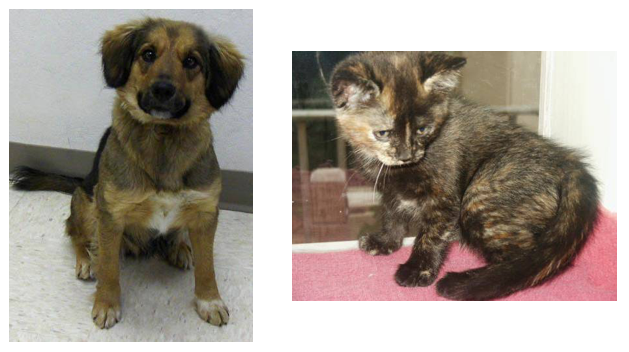

Nous emploierons ce jeu de données pour entraîner un réseau de neurones capable de **distinguer les chats des chiens**.  
Aujourd’hui, cela peut sembler banal, mais il y a encore quelques années, c’était un véritable **défi pour les systèmes de vision par ordinateur**.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# setting working Directory
import os
os.chdir('/content/drive/MyDrive/cat_dog_image_classification')

In [ ]:
%ls

 Cat_Dog_data/   __MACOSX/
 helper.py      'Part 7 - Loading Image Data (exo)_v2.ipynb'


# **Exercice :**
 ## Définissez ci-dessous les **transformations** pour les données d’entraînement et de test.
 ## Ne mettez pas encore la normalisation.


In [ ]:
data_dir = 'Cat_Dog_data/train'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(data_dir, transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

<Axes: >

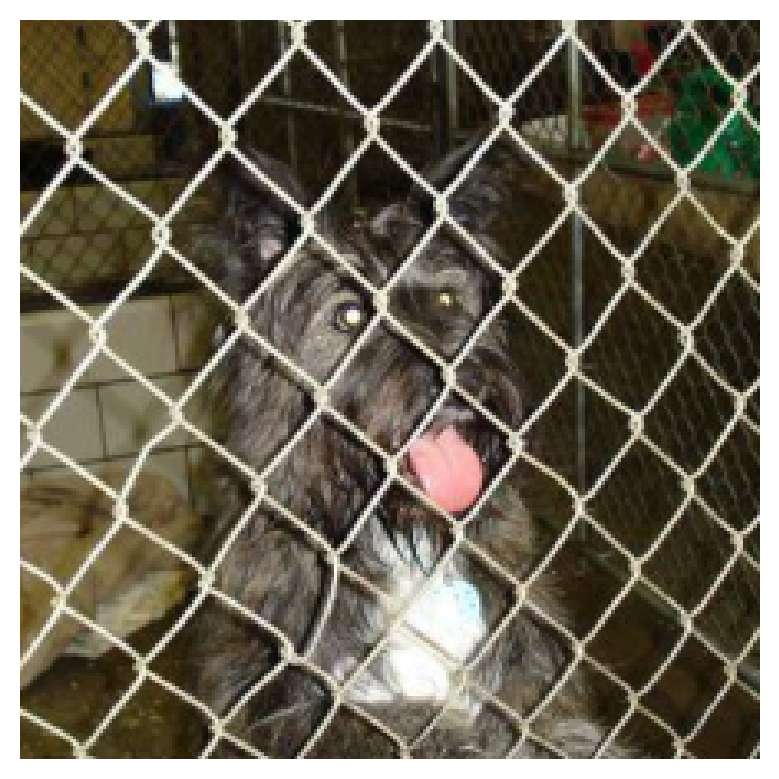

In [ ]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)

Si vous avez correctement chargé les données, vous devriez obtenir un affichage similaire à celui-ci (votre image sera différente) :




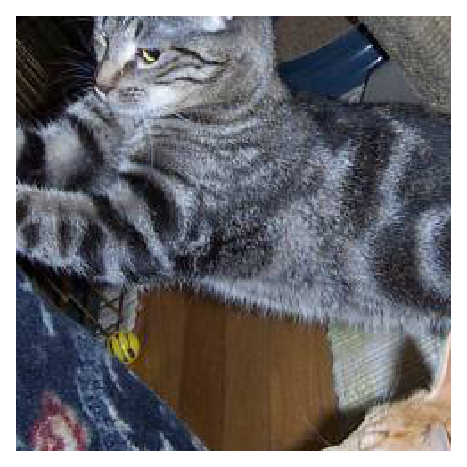

In [ ]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_transforms =train_transforms # Applying the same transformation
  # to the train data, if not our model could not make accurate prediction


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [ ]:
# change this to the trainloader or testloader
data_iter = iter(trainloader)

In [ ]:
images, labels = next(data_iter)
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

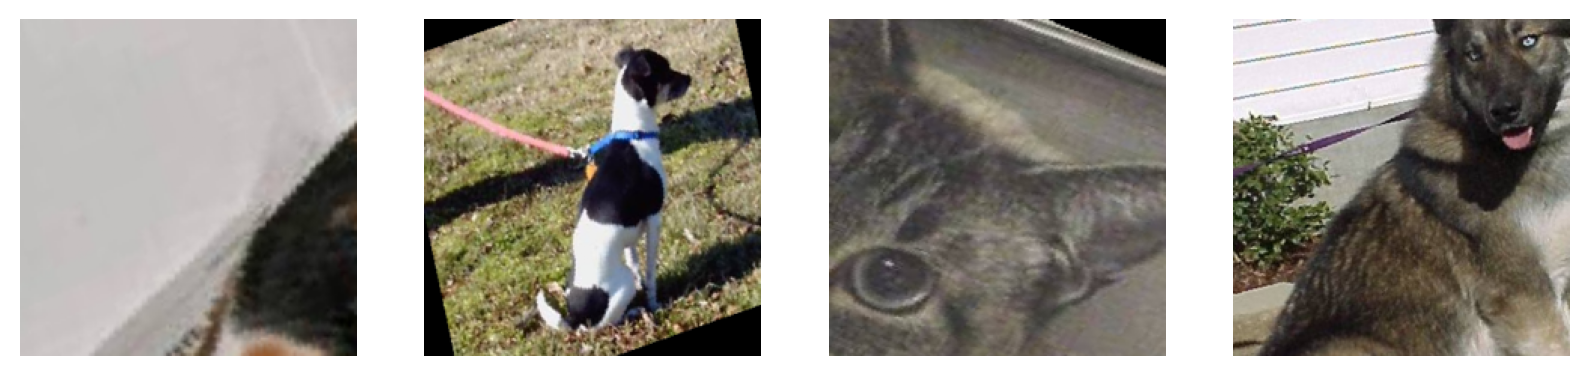

In [ ]:

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

Vos images transformées devraient ressembler à quelque chose comme ceci.




<center>Training examples:</center>


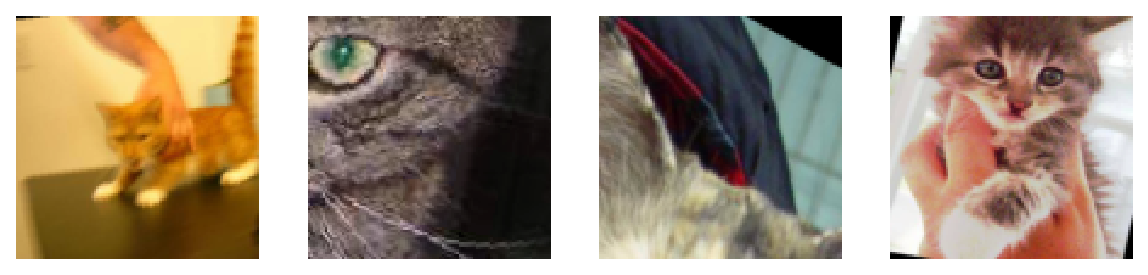

<center>Testing examples:</center>

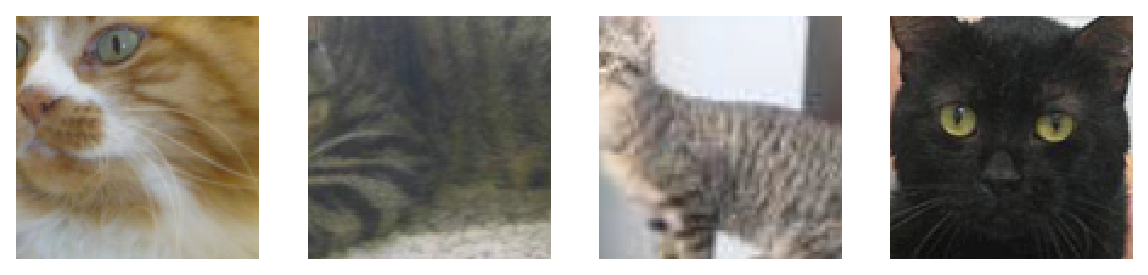


À ce stade, vous devriez être en mesure de charger les données pour l’entraînement et le test.  
Vous pouvez maintenant essayer de construire un réseau capable de **classer les chats et les chiens**.



In [ ]:
#  TODO: Attempt to build a network with CNN to classify cats vs dogs from this dataset
# --- créer un model from scratc
# I am defining the CNN model
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN (nn.Module):
  def __init__(self, input_size, n_feature, output_size):
    super(CNN, self).__init__()
    self.n_feature = n_feature
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
    self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
    self.fc1 = nn.Linear(n_feature*53*53,50)
    self.fc2 = nn.Linear(50,10)
    self.dropout_fc= nn.Dropout(0.25)
    # self.batch_norm_1d = nn.BatchNorm1d(n_feature)

  def forward(self, x, verbose=False):
    x = self.conv1(x)
    # x = self.batch_norm_1d(x)  # Permettre des taux d'apprentissage plus élevé en stabilisant l'entraînement.
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = x.view(-1, self.n_feature*53*53)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout_fc(x) # Désactiver certains neurones pour éviter l'overfitting
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1)
    return x

# Defini training and testing setup
def train(epoch, model):
  model = model.to(device)
  model.train()
  for batch_idx, (data, target) in enumerate(trainloader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if batch_idx%10 and  batch_idx>5:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

def test(model):
    model = model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(testloader.dataset)
    accuracy = 100. * correct / len(testloader.dataset)
    accuracy_list.append(accuracy)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        accuracy))

# Training our model
train_losses, test_losses = [], []
accuracy_list = []
input_size = 224 # hyperparameter
output_size = 2 # hyperparameter
n_features = 2 # hyperparameter
model_cnn = CNN(input_size, n_features, output_size)
model_cnn = model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)


# Visualisoing data
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_accs = [90.12, 93.87, 95.21, 96.05, 96.88]
val_accs = [92.45, 94.33, 95.10, 95.77, 96.21]

plt.plot(epochs, accuracy_list, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Progress')
plt.legend()
plt.show()

Train Epoch: 0 [192/22500 (1%)]	Loss: 1.791860
Train Epoch: 0 [224/22500 (1%)]	Loss: 1.524777
Train Epoch: 0 [256/22500 (1%)]	Loss: 1.105901
Train Epoch: 0 [288/22500 (1%)]	Loss: 0.608536
Train Epoch: 0 [352/22500 (2%)]	Loss: 0.092604
Train Epoch: 0 [384/22500 (2%)]	Loss: 0.054948
Train Epoch: 0 [416/22500 (2%)]	Loss: 0.042689
Train Epoch: 0 [448/22500 (2%)]	Loss: 0.055292
Train Epoch: 0 [480/22500 (2%)]	Loss: 0.022508
Train Epoch: 0 [512/22500 (2%)]	Loss: 0.016942
Train Epoch: 0 [544/22500 (2%)]	Loss: 0.036322
Train Epoch: 0 [576/22500 (3%)]	Loss: 0.012815
Train Epoch: 0 [608/22500 (3%)]	Loss: 0.007517
Train Epoch: 0 [672/22500 (3%)]	Loss: 0.002403
Train Epoch: 0 [704/22500 (3%)]	Loss: 0.019602
Train Epoch: 0 [736/22500 (3%)]	Loss: 0.012194
Train Epoch: 0 [768/22500 (3%)]	Loss: 0.007982
Train Epoch: 0 [800/22500 (4%)]	Loss: 0.001843
Train Epoch: 0 [832/22500 (4%)]	Loss: 0.007668
Train Epoch: 0 [864/22500 (4%)]	Loss: 0.004888
Train Epoch: 0 [896/22500 (4%)]	Loss: 0.002072
Train Epoch: 

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os

# ===================================================
# 1. Configuration
# ===================================================
data_dir = "Cat_Dog_data/train"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

batch_size = 32
img_size = 224  # Required size for ResNet
epochs = 10
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================
# 2. Transformations
# ===================================================
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ===================================================
# 3. Dataset & DataLoader
# ===================================================
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
val_data = datasets.ImageFolder(val_dir, transform=transform_val)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print(f"Classes: {train_data.classes}")  # should be ['cats', 'dogs']

# ===================================================
# 4. Load Pretrained ResNet
# ===================================================
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze early layers (optional, can unfreeze later for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)  # 2 classes: cat, dog
)

model = model.to(device)

# ===================================================
# 5. Loss & Optimizer
# ===================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=lr)

# ===================================================
# 6. Training Loop
# ===================================================
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

# ===================================================
# 7. Plot training curves
# ===================================================
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()


# TP – CNN “from scratch” vs Transfert Learning (Cats vs Dogs)

## Objectif

Comparer **un modèle CNN entraîné from scratch** et **un modèle en transfert d’apprentissage** sur le même jeu de données (cats vs dogs). Montrer l’impact du transfert learning sur la convergence, la performance et la robustesse.

## Ce qui est **obligatoire**

1. **Deux expériences distinctes**

   * Expérience A : CNN **from scratch** (architecture simple minimum 3 bloc avec conv).
   * Expérience B : **Transfert learning** (ex. ResNet, MobileNet, EfficientNet…), couches finales adaptées.
2. **Bonnes pratiques de régularisation**

   * Utiliser **Dropout** ET **Batch Normalization** (justifier où et pourquoi).
3. **Suivi des métriques**

   * **Training loss**, **Accuracy**, **Précision**, **Recall** à chaque époque (et idéalement sur train/val si vous faites une validation).
   * Tracer des **courbes** et **comparer** les deux approches.
4. **Optimisation**

   * Tester au moins **2 optimiseurs** (ex. SGD et Adam).
   * Chercher un **bon learning rate** (essais ou scheduler).
5. **GPU**

   * Entraîner **sur GPU** si disponible (vérification et mention dans README).
6. **Persistance du modèle**

   * **Sauvegarder** le meilleur modèle (.pt/.pth) localement (ne **pas** pousser dans GitHub).
   * **Recharger** le modèle pour faire le **test final** et rapporter les métriques.
7. **Reproductibilité**

   * Fixer un **seed**

## Ce qui est **souhaité (bonus)**

* **Split train/validation** (clair et justifié).
* **Data augmentation** raisonnable.
* **Scheduler** (ex. StepLR, CosineAnnealingLR).
* **Matrice de confusion** et quelques **erreurs typiques** commentées.
* Journalisation (TensorBoard/W&B) — sans pousser les fichiers lourds.

## Données

* Utilisez le même corpus **Cats vs Dogs** que vu en cours (ou équivalent).
* Ne **poussez pas** les données sur GitHub. Indiquez seulement **comment** les télécharger/placer.

## Structure du dépôt GitHub (exemple)

```
cnn-catsdogs-<NomPrenom>/
├─ notebook.ipynb
├─ .gitignore
├─ requirements.txt (ou environment.yml)
├─ README.md
└─ LICENSE (optionnel)
```

### `.gitignore` (minimum)

```
data/
*.pt
*.pth
runs/
checkpoints/
```

## Contenu attendu du **README.md**

* **Titre & objectif** du projet.
* **Environnement** ( `pip install -r requirements.txt` ou `conda env create -f environment.yml`).
* **Organisation des données** (où télécharger, où placer les dossiers).
* **Commandes pour entraîner** :

  * From scratch : arguments clés (batch size, lr, epochs, optimiser, dropout, BN, scheduler…).
  * Transfert learning : même chose + quelle base (gel des couches ou fine-tuning).
* **Commandes pour évaluer / recharger le modèle** (chemin du checkpoint local).
* **Résultats** : tableaux + courbes (loss/accuracy/précision/recall) pour les deux expériences, **comparaison et analyse** (2–3 paragraphes).
* **Limites & pistes d’amélioration** (brèves).

## Évaluation (grille indicative)

* Rigueur expérimentale & métriques (30 %)
* Qualité des modèles & optimisation (25 %)
* Clarté du code & structure du dépôt (20 %)
* README (reproductibilité, analyse, figures) (20 %)
* Bonus (val split, augmentation, scheduler, confusion matrix) (5 %)

## Remise

* **Poussez votre code sur GitHub** (sans données ni modèles).
* Envoyez **le lien du dépôt** à **[diallomous@gmail.com](mailto:diallomous@gmail.com)**
* **Date limite : mercredi  22 octobre 2025 à 18:00 (Africa/Dakar).**

> Rappel : ne chargez pas les fichiers lourds (datasets, `.pt/.pth`). Assurez-vous que votre dépôt permet de **reproduire** les expériences via les instructions du README.
